In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np
import csv
import re

from sklearn.linear_model import LinearRegression
mpl.rcParams['figure.dpi'] = 800

In [2]:
# Fittting
def linearFit(orig_perf, ood_perf, x_values):
    """
    Linearly fit a function from original performance to OOD performnce. Return the
    prediction on x_values
    """
    reg = LinearRegression().fit(np.array(orig_perf).reshape(-1, 1), np.array(ood_perf))
    return reg.predict(np.array(x_values).reshape(-1, 1))

In [3]:
gen_models = {'T5v1.1', 'BART'}
ext_models = {'BERT', 'RoBERTa'}

In [4]:
def plot_orig_vs_OOD(performance_dict, metric_name, in_domain, out_domain, xlim=[75, 100]):
    """
    performance dict (dict()): contains the dictionary whose keys are model name (e.g. bert, bart), 
        and values are dict(), where key is the dataset name and values are the corresponding
        performance.
    in_domain (str)
    out_domain (str)
    """
    colors = ['#E66100', '#40B0A6', '#FFC107', '#004D40', '#D81B60', '#7570B3', '#0C7BDC', '#785EF0']
    aggregate_avg_orig_perf = []
    aggregate_avg_ood_perf = []

    aggregate_avg_orig_perf_wo_tok = []
    aggregate_avg_ood_perf_wo_tok = []

    aggregate_avg_orig_perf_ext = []
    aggregate_avg_ood_perf_ext = []

    aggregate_avg_orig_perf_gen = []
    aggregate_avg_ood_perf_gen = []

    for model in performance_dict.keys():
        aggregate_avg_orig_perf += performance_dict[model][in_domain].tolist()
        aggregate_avg_ood_perf += performance_dict[model][out_domain].tolist()
        if 'tokenizer' not in model.lower():
            aggregate_avg_orig_perf_wo_tok += performance_dict[model][in_domain].tolist()
            aggregate_avg_ood_perf_wo_tok += performance_dict[model][out_domain].tolist()
        if model in ext_models:
            plt.scatter(x=performance_dict[model][in_domain], y=performance_dict[model][out_domain], color=colors.pop(0), marker='*', label=model, alpha=0.6)

            aggregate_avg_orig_perf_ext += performance_dict[model][in_domain].tolist()
            aggregate_avg_ood_perf_ext += performance_dict[model][out_domain].tolist()
        else:
            plt.scatter(x=performance_dict[model][in_domain], y=performance_dict[model][out_domain], color=colors.pop(0), label=model, alpha=0.6)

            aggregate_avg_orig_perf_gen += performance_dict[model][in_domain].tolist()
            aggregate_avg_ood_perf_gen += performance_dict[model][out_domain].tolist()
    plt.xlabel(in_domain, fontsize=10)
    plt.ylabel(out_domain, fontsize=10)
    plt.suptitle('Model transfer ' + metric_name + ' from ' + in_domain + " to " + out_domain)
    plt.xlim(xlim)
    plt.ylim([10, 100])

    plt.plot(np.array([0, 50, 100]), linearFit(aggregate_avg_orig_perf, aggregate_avg_ood_perf, [0, 50, 100]), color='blue', label='Linear Fit')
    plt.plot(np.array([0, 50, 100]), linearFit(aggregate_avg_orig_perf_wo_tok, aggregate_avg_ood_perf_wo_tok, [0, 50, 100]), color='yellow', label='Linear Fit /wo Tok')
    # plt.plot(np.array([0, 50, 100]), linearFit(aggregate_avg_orig_perf_ext, aggregate_avg_ood_perf_ext, [0, 50, 100]), color='blue', label='Ext Linear Fit')
    # plt.plot(np.array([0, 50, 100]), linearFit(aggregate_avg_orig_perf_gen, aggregate_avg_ood_perf_gen, [0, 50, 100]), color='yellow', label='Gen Linear Fit')
    plt.legend()
    plt.show()


In [5]:
def plot_macro_F1(performance_dict, in_domain, metric_name='F1', xlim=[75, 100]):
    """
    Plot the average F1 of models across dataset
    performance dict (dict()): contains the dictionary whose keys are model name (e.g. bert, bart), 
        and values are dict(), where key is the dataset name and values are the corresponding
        performance.
    in_domain (str)
    """
    colors = ['#E66100', '#40B0A6', '#FFC107', '#004D40', '#D81B60', '#7570B3', '#0C7BDC', '#785EF0']
    model_list = list(performance_dict.keys())
    dataset_list = list(performance_dict[model_list[0]].keys())
    dataset_list.remove(in_domain)

    aggregate_avg_orig_perf = []
    aggregate_avg_ood_perf = []
    aggregate_avg_orig_perf_wo_tok = []
    aggregate_avg_ood_perf_wo_tok = []

    aggregate_avg_orig_perf_ext = []
    aggregate_avg_ood_perf_ext = []
    aggregate_avg_orig_perf_gen = []
    aggregate_avg_ood_perf_gen = []

    for model_idx, model in enumerate(model_list):
        # Compute the average F1 for each model, and plot them
        avg_F1 = np.zeros(len(performance_dict[model][in_domain]))
        for dataset_idx, dataset in enumerate(dataset_list):
            if dataset != in_domain:
                avg_F1 += performance_dict[model][dataset]
        avg_F1 /= (len(dataset_list)-1)
        aggregate_avg_orig_perf += performance_dict[model][in_domain].tolist()
        aggregate_avg_ood_perf += avg_F1.tolist()
        if 'tokenizer' not in model.lower():
            aggregate_avg_orig_perf_wo_tok += performance_dict[model][in_domain].tolist()
            aggregate_avg_ood_perf_wo_tok += avg_F1.tolist()
        if model in ext_models:
            aggregate_avg_orig_perf_ext += performance_dict[model][in_domain].tolist()
            aggregate_avg_ood_perf_ext += avg_F1.tolist()
            plt.scatter(x=performance_dict[model][in_domain], y=avg_F1, color=colors.pop(0), marker='*', label=model, alpha=0.6)
        else:
            aggregate_avg_orig_perf_gen += performance_dict[model][in_domain].tolist()
            aggregate_avg_ood_perf_gen += avg_F1.tolist()
            plt.scatter(x=performance_dict[model][in_domain], y=avg_F1, color=colors.pop(0), label=model, alpha=0.6)

    plt.xlabel(in_domain, fontsize=10)
    plt.ylabel("Out of domain performance", fontsize=10)
    plt.suptitle('Model transfer ' + metric_name + ' from ' + in_domain + " to OOD datasets")
    plt.xlim(xlim)
    plt.ylim([10, 100])
    plt.plot(np.array([0, 50, 100]), linearFit(aggregate_avg_orig_perf, aggregate_avg_ood_perf, [0, 50, 100]), color='blue', label='Linear Fit')
    plt.plot(np.array([0, 50, 100]), linearFit(aggregate_avg_orig_perf_wo_tok, aggregate_avg_ood_perf_wo_tok, [0, 50, 100]), color='yellow', label='Linear Fit /wo Tok')
    # plt.plot(np.array([0, 50, 100]), linearFit(aggregate_avg_orig_perf_ext, aggregate_avg_ood_perf_ext, [0, 50, 100]), color='blue', label='Ext Linear Fit')
    # plt.plot(np.array([0, 50, 100]), linearFit(aggregate_avg_orig_perf_gen, aggregate_avg_ood_perf_gen, [0, 50, 100]), color='yellow', label='Gen Linear Fit')
    plt.legend()
    plt.show()

In [6]:
def plot_aggregate_OOD(performance_dict, in_domain, metric_name, xlim=[75, 100]):
    """
    performance dict (dict()): contains the dictionary whose keys are model name (e.g. bert, bart), 
        and values are dict(), where key is the dataset name and values are the corresponding
        performance.
    in_domain (str)
    """
    markers = ['o', '^', 's', '*', 'p']
    colors = ['#E66100', '#FFC107', '#D81B60', '#004D40', '#7570B3', '#0C7BDC', '#40B0A6', '#785EF0', '#999999']
    model_list = list(performance_dict.keys())
    dataset_list = list(performance_dict[model_list[0]].keys())
    
    for model_idx, model in enumerate(model_list):
        for dataset_idx, dataset in enumerate(dataset_list):
            plt.scatter(x=performance_dict[model][in_domain], y=performance_dict[model][dataset], marker=markers[model_idx], color=colors[dataset_idx], alpha=0.7)
    plt.xlabel(in_domain, fontsize=10)
    plt.ylabel("Out of domain " + metric_name, fontsize=10)
    plt.suptitle('Model transfer ' + metric_name + ' from ' + in_domain + " to OOD datasets")
    plt.xlim(xlim)
    plt.ylim([10, 100])
    # plt.plot(np.array([0, 50, 100]), linearFit(aggregate_avg_orig_perf, aggregate_avg_ood_perf, [0, 50, 100]), color='black', label='Linear Fit')

    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    handles = [f('s', colors[i]) for i in range(len(dataset_list))]
    handles += [f(markers[i], 'k') for i in range(len(model_list))]
    # handles += [f('_', 'k')]
    labels = dataset_list + model_list

    plt.legend(handles, labels)
    plt.show()

In [7]:
def construct_performance_dict(metric_name, base_dataset='squad'):
    """
    Construct performance dict
    Return a performance dict
    """
    performance_dict = {'RoBERTa':{}, 'BERT':{}, 'BART':{}, 'T5v1.1':{},  'BART-Tokenizer':{}}
    dataset_list = ["squad", "NewsQA", "NaturalQuestions", "SearchQA", "bioasq", "TriviaQA", "duorc", "TextbookQA"]
    # Load CSV file
    file = open('perf_' + base_dataset +'.csv')
    csvreader = csv.reader(file)
    header = next(csvreader)
    
    for row in csvreader:
        # For each model, load in and out domain performance
        for model in performance_dict.keys():
            if model.lower() + "-" in row[0].lower() or 'tokenizer' in model.lower() and 'tokenizer' in row[0].lower():
                for dataset in dataset_list:
                    if metric_name == "F1":
                        metric = float(re.sub('[0-9\\.0-9]*/', '', row[header.index(dataset)]))
                    else:
                        metric = float(re.sub('/[0-9\\.0-9]*', '', row[header.index(dataset)]))

                    if dataset in performance_dict[model].keys():
                        performance_dict[model][dataset].append(metric)
                    else:
                        performance_dict[model][dataset] = [metric]

    # Convert the values to numpy arrays
    for model in performance_dict.keys():
        for dataset in performance_dict[model].keys():
            performance_dict[model][dataset] = np.array(performance_dict[model][dataset])

    return performance_dict

{'RoBERTa': {'squad': array([91.8 , 91.68, 91.49]), 'NewsQA': array([56.24, 52.66, 53.33]), 'NaturalQuestions': array([59.82, 61.19, 60.1 ]), 'SearchQA': array([22.92, 24.6 , 22.53]), 'bioasq': array([61.54, 63.5 , 62.36]), 'TriviaQA': array([64.94, 65.82, 64.2 ]), 'duorc': array([58.16, 57.24, 59.35]), 'TextbookQA': array([47.71, 46.46, 43.52])}, 'BERT': {'squad': array([87.31, 87.61, 87.56]), 'NewsQA': array([54.11, 51.99, 52.31]), 'NaturalQuestions': array([58.22, 56.77, 56.12]), 'SearchQA': array([30.58, 29.98, 30.49]), 'bioasq': array([53.62, 55.61, 54.3 ]), 'TriviaQA': array([56.94, 56.6 , 56.92]), 'duorc': array([50.06, 48.59, 52.06]), 'TextbookQA': array([41.07, 38.85, 39.48])}, 'BART': {'squad': array([87.68, 87.5 , 87.36, 88.59, 88.34, 88.21]), 'NewsQA': array([54.41, 52.31, 53.67, 56.14, 55.63, 54.24]), 'NaturalQuestions': array([48.25, 50.  , 47.73, 49.18, 49.77, 51.53]), 'SearchQA': array([22.26, 23.95, 23.85, 28.36, 24.22, 24.47]), 'bioasq': array([55.09, 54.11, 54.05, 57

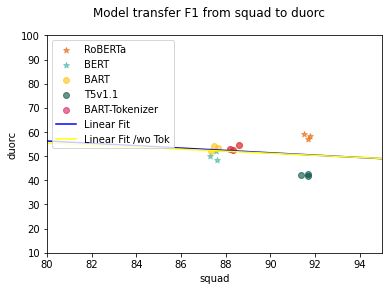

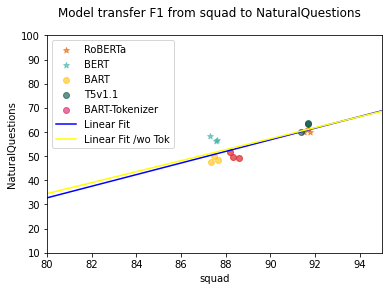

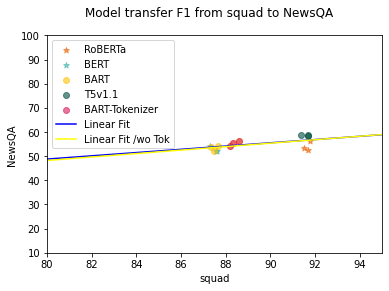

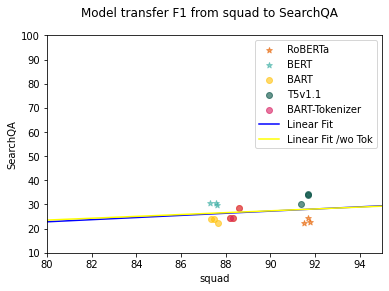

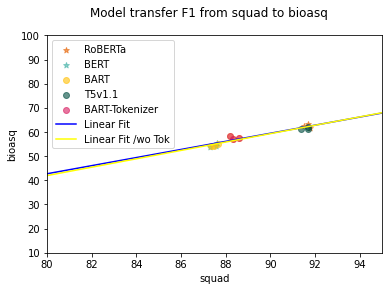

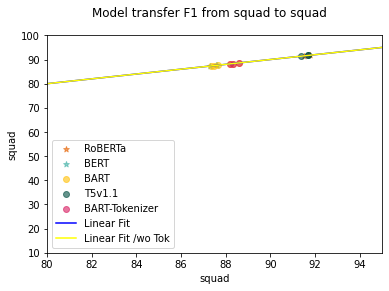

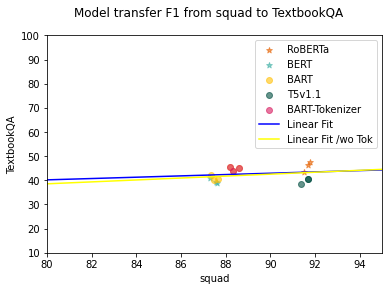

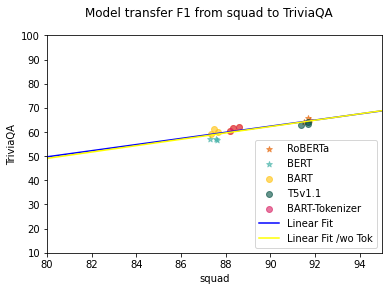

In [8]:
metric_name = "F1"
domains = ['duorc', 'NaturalQuestions', 'NewsQA', 'SearchQA', "bioasq", 'squad', 'TextbookQA', 'TriviaQA']
performance_dict = construct_performance_dict(metric_name, base_dataset='squad')
print(performance_dict)
for domain in domains:
    ## Generate plot 1, where the x-axis is the orig performance and y-axis is the OOD performance
    plot_orig_vs_OOD(performance_dict, metric_name, in_domain='squad', out_domain=domain, xlim=[80,95])

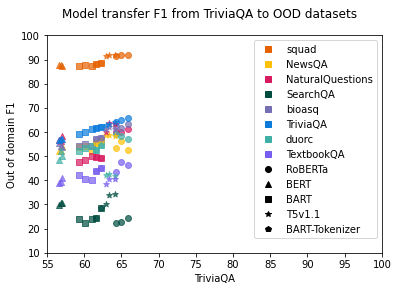

In [20]:
# Aggregate Plot
plot_aggregate_OOD(performance_dict, 'TriviaQA', metric_name)

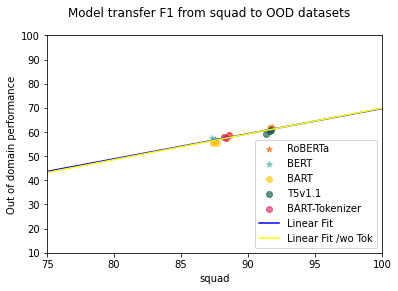

In [9]:
plot_macro_F1(performance_dict, 'squad', metric_name)

#### Experiments to plot the fixing tokenizer v.s. unfixed tokenizer

In [10]:
def construct_performance_dict_tokenizer_exp(metric_name, base_dataset='squad'):
    """
    Construct performance dict for fixing the tokenizer experiment
    Return a performance dict
    """
    performance_dict = {'BART':{}, 'BART-Tokenizer':{}}
    dataset_list = ["squad", "NewsQA", "NaturalQuestions", "SearchQA", "bioasq", "TriviaQA", "duorc", "TextbookQA"]
    # Load CSV file
    file = open('perf_' + base_dataset +'.csv')
    csvreader = csv.reader(file)
    header = next(csvreader)
    
    for row in csvreader:
        # For each model, load in and out domain performance
        for model in performance_dict.keys():
            if model.lower() in row[0].lower() or 'tokenizer' in model.lower() and 'tokenizer' in row[0].lower():
                for dataset in dataset_list:
                    if metric_name == "F1":
                        metric = float(re.sub('[0-9\\.0-9]*/', '', row[header.index(dataset)]))
                    else:
                        metric = float(re.sub('/[0-9\\.0-9]*', '', row[header.index(dataset)]))

                    if dataset in performance_dict[model].keys():
                        performance_dict[model][dataset].append(metric)
                    else:
                        performance_dict[model][dataset] = [metric]

    # Convert the values to numpy arrays
    for model in performance_dict.keys():
        for dataset in performance_dict[model].keys():
            performance_dict[model][dataset] = np.array(performance_dict[model][dataset])

    return performance_dict

{'BART': {'squad': array([87.68, 87.5 , 87.36, 88.59, 88.34, 88.21]), 'NewsQA': array([54.41, 52.31, 53.67, 56.14, 55.63, 54.24]), 'NaturalQuestions': array([48.25, 50.  , 47.73, 49.18, 49.77, 51.53]), 'SearchQA': array([22.26, 23.95, 23.85, 28.36, 24.22, 24.47]), 'bioasq': array([55.09, 54.11, 54.05, 57.62, 57.26, 58.49]), 'TriviaQA': array([60.08, 61.05, 59.31, 62.23, 61.53, 60.34]), 'duorc': array([53.22, 54.24, 52.13, 54.78, 52.63, 53.02]), 'TextbookQA': array([40.53, 40.28, 42.32, 44.92, 43.92, 45.72])}, 'BART-Tokenizer': {'squad': array([88.59, 88.34, 88.21]), 'NewsQA': array([56.14, 55.63, 54.24]), 'NaturalQuestions': array([49.18, 49.77, 51.53]), 'SearchQA': array([28.36, 24.22, 24.47]), 'bioasq': array([57.62, 57.26, 58.49]), 'TriviaQA': array([62.23, 61.53, 60.34]), 'duorc': array([54.78, 52.63, 53.02]), 'TextbookQA': array([44.92, 43.92, 45.72])}}


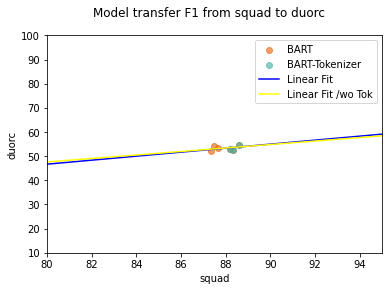

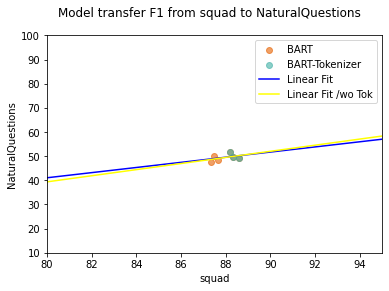

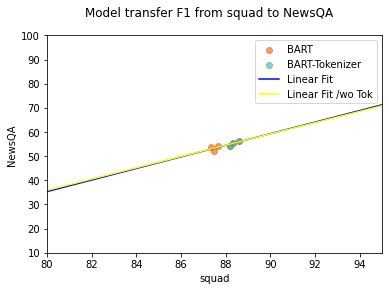

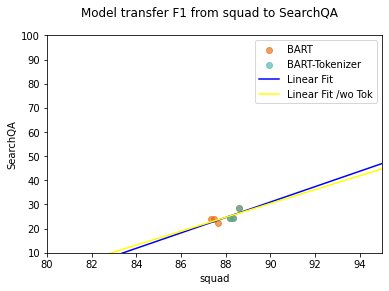

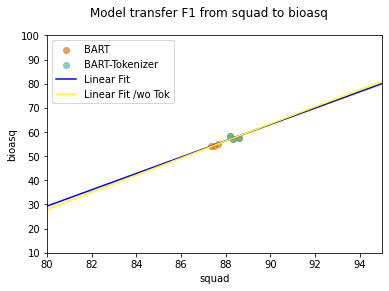

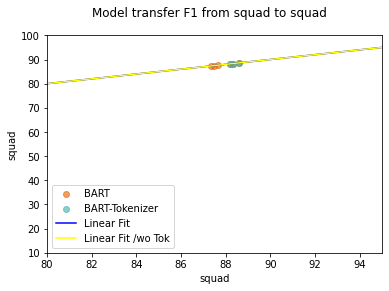

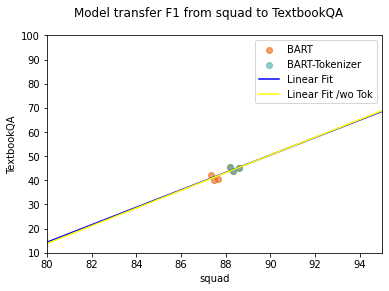

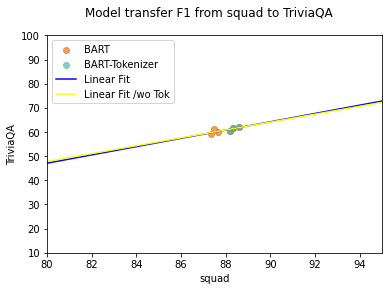

In [11]:
metric_name = "F1"
domains = ['duorc', 'NaturalQuestions', 'NewsQA', 'SearchQA', "bioasq", 'squad', 'TextbookQA', 'TriviaQA']
performance_dict = construct_performance_dict_tokenizer_exp(metric_name, base_dataset='squad')
print(performance_dict)
for domain in domains:
    ## Generate plot 1, where the x-axis is the orig performance and y-axis is the OOD performance
    plot_orig_vs_OOD(performance_dict, metric_name, in_domain='squad', out_domain=domain, xlim=[80, 95])

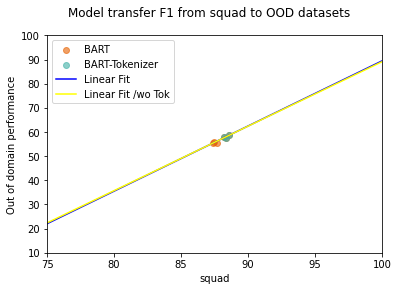

In [12]:
plot_macro_F1(performance_dict, 'squad', metric_name)